In [1]:
import sys
sys.path.append('../../geoml')

from ee_pipeline import ee_s2
from geo import band_stats

ModuleNotFoundError: No module named 'ee_pipeline'

In [ ]:
import geopandas as gpd
import rasterio as r
from pathlib import Path
import matplotlib.pyplot as plt
import rioxarray as rio
import pandas as pd

In [ ]:
raw_dir = Path('data/raw')
bldg_fp = raw_dir /'buildings.geojson'
ndvi_fp = raw_dir / 'ndvi.tif'
ndmi_fp = raw_dir / 'ndmi_median.tif'
evi_fp = raw_dir / 'evi_median.tif'
bu_fp = raw_dir / 'bu_median.tif'
ndbi_fp = raw_dir / 'ndbi_median.tif'


s2_fp = raw_dir / 'sentinel2.tif'
train_fp = raw_dir / 'greenroof_train.geojson'
s2_bands_fp = 'meta/sentinel_bands.csv'
ndvi_reproj_fp = str(ndvi_fp).replace('raw', 'prc')
evi_reproj_fp = str(evi_fp).replace('raw', 'prc')
bu_reproj_fp = str(bu_fp).replace('raw', 'prc')
ndmi_reproj_fp = str(ndmi_fp).replace('raw', 'prc')
ndbi_reproj_fp = str(ndbi_fp).replace('raw', 'prc')

In [ ]:
evi = rio.open_rasterio(evi_reproj_fp)
ndmi = rio.open_rasterio(ndmi_reproj_fp)
ndbi = rio.open_rasterio(ndbi_reproj_fp)
bu = rio.open_rasterio(bu_reproj_fp)
s2 = rio.open_rasterio(s2_fp)
# dsm = rio.open_rasterio(dsm_fp)
s2 = s2 / 10000
train=gpd.read_file(train_fp)
bldg = gpd.read_file(bldg_fp)
bldg['fid'] = bldg.index
bldg.set_index('fid', inplace = True)


train = train.to_crs(train.estimate_utm_crs())
bldg = bldg.to_crs(bldg.estimate_utm_crs())

In [ ]:
s2_bands =pd.read_csv(s2_bands_fp)


sel_bands = s2_bands[s2_bands.mission == 'S2A'].set_index('band').loc[['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B8A', 'B11', 'B12']]

sel_wv = sel_bands.wavelength_nm.values


In [ ]:
train_zones = train.dissolve(by='class_name')

In [ ]:
groof = train[train.class_name == 'green_roof']
roof = train[train.class_name == 'roof']

# Get Green Roof Pixel Values for EVI and BU
groof_evi = evi.rio.clip(groof.geometry.values, crs=groof.crs)
groof_bu = bu.rio.clip(groof.geometry.values, crs=groof.crs)

# Get Roof Pixel Values for EVI and BU
roof_evi = evi.rio.clip(roof.geometry.values, crs=groof.crs)
roof_bu = bu.rio.clip(roof.geometry.values, crs=groof.crs)


import numpy as np
fill_value = -np.inf
# Get Green Roof Values
groof_evi_val = groof_evi.values.ravel()
groof_evi_val= groof_evi_val[groof_evi_val != fill_value]
groof_bu_val = groof_bu.values.ravel()
groof_bu_val= groof_bu_val[groof_bu_val != fill_value]

# Get Roof Values
roof_evi_val = roof_evi.values.ravel()
roof_evi_val= roof_evi_val[roof_evi_val != fill_value]
roof_bu_val = roof_bu.values.ravel()
roof_bu_val= roof_bu_val[roof_bu_val != fill_value]

groof_val_df = pd.DataFrame(dict(evi = groof_evi_val, bu = groof_bu_val, class_name = ['green_roof' for x in range(0, len(groof_evi_val))]))
roof_val_df = pd.DataFrame(dict(evi = roof_evi_val, bu = roof_bu_val, class_name = ['roof' for x in range(0, len(roof_evi_val))]))

val_df = pd.concat([groof_val_df,roof_val_df])

Text(0.5, 0, 'Built-up Index')

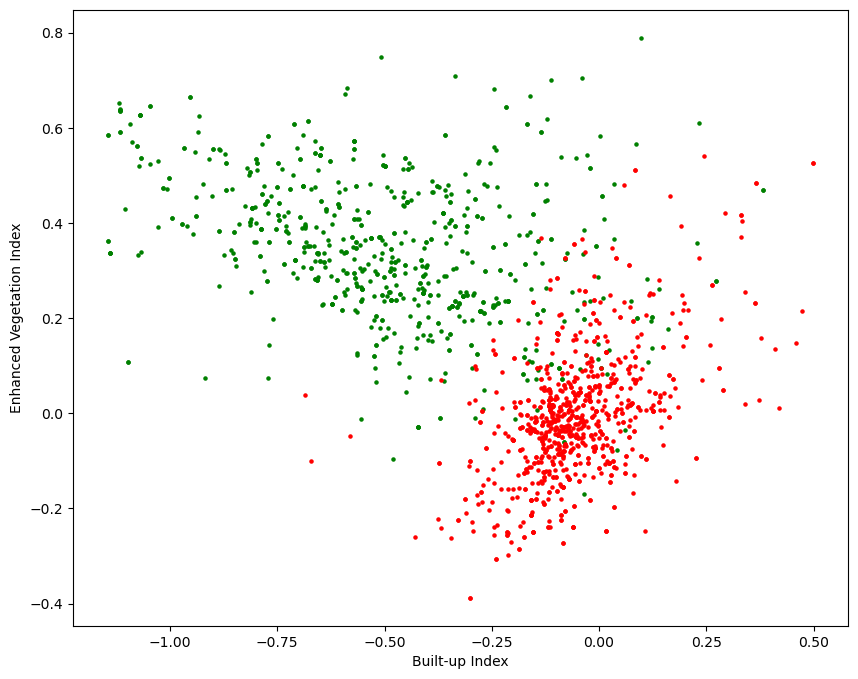

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(groof_val_df['bu'], groof_val_df['evi'], color = 'green', s = 5)
ax.scatter(roof_val_df['bu'], roof_val_df['evi'], color = 'red', s = 5)

ax.set_ylabel('Enhanced Vegetation Index')
ax.set_xlabel('Built-up Index')

In [2]:
bldg_stats_evi = band_stats(zones = bldg, raster = evi)
bldg_stats_bu = band_stats(zones = bldg, raster = bu)
# bldg_stats_s2 = band_stats(zones = bldg, raster = s2)
# s2_stats = band_stats(zones = train_zones, raster =s2)
# s2_stats = s2_stats.set_index('class_name')
# s2_stats['wavelength_nm'] = s2_stats.band.apply(lambda b: sel_wv[b-1])

# nvdi_stats = band_stats(zones = train_zones, raster =ndvi)
# dsm_stats = band_stats(zones = train_zones, raster = dsm)

NameError: name 'band_stats' is not defined

In [ ]:
# bldg_stats_gdf = bldg.join(bldg_stats.set_index('fid'))[['median','geometry']]

## Get Building Roof Characteristics

In [ ]:
import xarray as xr

evi.name ='evi'
ndwi.name = 'ndwi'
bu.name = 'bu'
ndbi.name = 'ndbi'
X = xr.merge([evi, ndmi, bu,ndbi])

In [ ]:
bldg_class = bldg.sjoin(train)
bldg_groof=bldg_class[bldg_class.class_name =='green_roof']
bldg_roof=bldg_class[bldg_class.class_name =='roof']
geom = bldg_groof.iloc[1].geometry



def rooftop_parameters(X, geom, threshold = 0.2):
    '''
    Compute Roof Top characteristics based on spectral indces
    '''
    X_clip= X.rio.clip([geom])
    X_clip = X_clip.where(X_clip != -np.inf)
    evi_vals= X_clip.evi.values[~X_clip.evi.isnull()]
    ndbi_vals= X_clip.ndbi.values[~X_clip.ndbi.isnull()]


    np.sum((~X_clip.where(X_clip != -np.inf).evi.isnull().values))
    pixel_count = np.sum(~X_clip.evi.isnull().values)
    veg_count = X_clip.evi.where(X_clip.evi > threshold).count().values
    veg_pct = veg_count / pixel_count
    evi_q3 = np.percentile(evi_vals ,q=75)
    evi_q2 = np.percentile(evi_vals ,q=50)
    bu_mean = (X_clip.bu.mean()).values
    ndbi_mean = ndbi_vals.mean()
    ndbi_q3 = np.percentile(ndbi_vals,q=75)
    ndbi_q2 = np.percentile(ndbi_vals,q=50)

    return dict(
    pixel_count = pixel_count,
    veg_count = veg_count,
    veg_pct = veg_pct,
    # evi_mean_weighted=evi_mean_weighted,
    evi_q3 = evi_q3,
    evi_q2= evi_q2,
    # bu_count = X_clip.bu.where(X_clip.bu > threshold).count().values,
    bu_mean = bu_mean,
    # ndmi_count = X_clip.ndmi.where(X_clip.ndmi > threshold).count().values,
    ndbi_mean = ndbi_mean,
    ndbi_q3 = ndbi_q3,
    ndbi_q2 = ndbi_q2
    )


rooftop_params= pd.DataFrame([rooftop_parameters(X, geom,0.2) for geom in bldg_class.geometry]).astype(float)

In [ ]:
bldg_params = bldg_class[['class_name', 'geometry']].reset_index(drop=True).join(rooftop_params).drop_duplicates('geometry')


bldg_params['veg_pct'] = bldg_params['veg_count'] / bldg_params['pixel_count']

bldg_params.round(2).sort_values('class_name').groupby('class_name').evi_q2.describe()

# bldg_params

,count,mean,std,min,25%,50%,75%,max
class_name,,,,,,,,
green_roof,36.0,0.184444,0.136705,-0.01,0.08,0.155,0.2625,0.55
roof,24.0,0.047500,0.134075,-0.12,-0.03,-0.005,0.0825,0.40


Text(0.5, 0, 'Built-up Index')

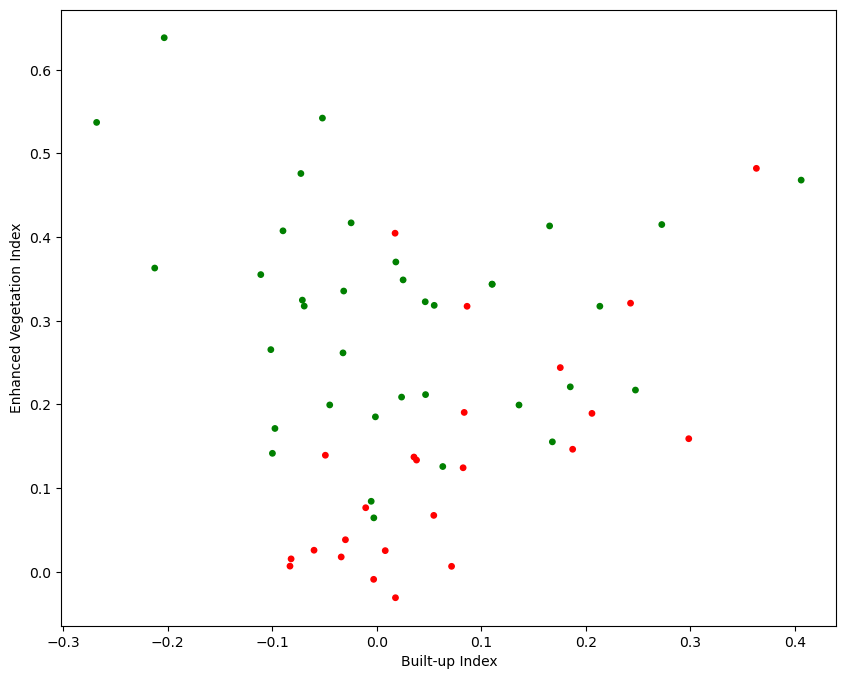

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))

ax.scatter(bldg_params['ndbi_q3'], bldg_params['evi_q3'], 
           c = ['green' if x == 'green_roof' else 'red' for x in bldg_params.class_name], 
           s = 15)
# ax.scatter(bldg_params['bu'], bldg_params['evi'], color = 'red', s = 5)

ax.set_ylabel('Enhanced Vegetation Index')
ax.set_xlabel('Built-up Index')

In [ ]:
stats_df = bldg_stats_evi.set_index('fid').join(bldg_stats_bu.set_index('fid'), rsuffix = '_bu')

stats_df = stats_df.dropna()
stats_df = stats_df[(stats_df <= 1) & (stats_df >= -1)].dropna()

NameError: name 's2_stats' is not defined

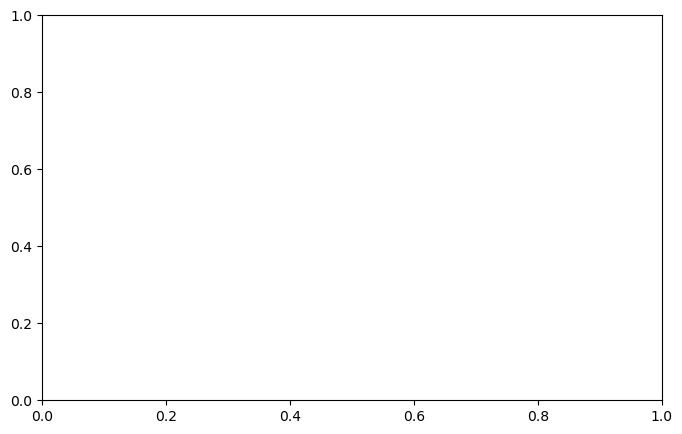

In [ ]:
import matplotlib.pyplot as plt

# Assume s2_stats is a DataFrame with columns: 'class_name', 'median', 'mean'
# Plot median and mean NDVI for each class_name

fig, ax = plt.subplots(figsize=(8, 5))


ax.plot(s2_stats.loc['green_roof']['wavelength_nm'],s2_stats.loc['green_roof']['median'], label ='Green Roof', color = 'green')
ax.plot(s2_stats.loc['roof']['wavelength_nm'],s2_stats.loc['roof']['median'], label ='Roof', color = 'red')

ax.legend()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Surface Reflectance')

In [ ]:
bldg_class[['class_name','geometry']].drop_duplicates('geometry').to_file('data/prc/bldg_class.geojson')